In [156]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import os
import zipfile
import scipy
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from theano import tensor as tt
from theano import shared

%matplotlib inline

In [157]:
if not os.path.isfile('../../data/osha/osha_norm_naics.csv'):
    with zipfile.ZipFile('../../data/osha/osha_norm_naics.zip','r') as zfile:
        zfile.extractall('../../data/osha')
osha = pd.read_csv('../../data/osha/osha_norm_naics.csv', dtype={'naics_code':str, 'sic_code':str},
                  na_values = ["", " ","NaN", "nan", "NA", "na", "Na"])
osha = osha[['date_sampled','inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name', 'subsector_name',
             'industry_group_name', 'conc_mgm3', 'sample_type', 'unit_of_measurement', 'sample_result']]  # keep only cols we need
osha['date_sampled'] = osha['date_sampled'].str.slice(0,4).astype(int)
osha = osha[~osha['sector_name'].isin(["Undefined/Multiple"])]
osha = osha.drop(osha[osha['sample_type']=='B'].index)
#osha = osha.drop(osha[osha['conc_mgm3']>10000].index)
osha = osha.dropna(subset=['conc_mgm3', 'sector_name'])
osha['detected'] = np.where(osha['conc_mgm3'] > 0, 1, 0)
osha = osha[osha['detected']==1]
osha['log_mgm3'] = np.log10(osha['conc_mgm3'])

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,7,11,20,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [158]:
osha = osha.groupby(['inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name',
                     'subsector_name', 'industry_group_name'], as_index=False).median(numeric_only=True)
osha.head(6)

,inspection_number,establishment_name,preferred_name,naics_unified,sector_name,subsector_name,industry_group_name,date_sampled,conc_mgm3,sample_result,detected,log_mgm3
0,29067,"GARMAT USA, INC.",Iron oxide,332322,Manufacturing,Fabricated Metal Product Manufacturing,Architectural and Structural Metals Manufacturing,2011.0,1.450061,1.450061,1.0,0.160109
1,29206,Polar Corporation,Iron oxide,811310,Other Services,Repair and Maintenance,Commercial and Industrial Machinery and Equipm...,2011.0,2.316146,2.316146,1.0,0.106328
2,29251,"Jobsite, Inc.",Iron oxide,333517,Manufacturing,Machinery Manufacturing,Metalworking Machinery Manufacturing,2011.0,0.284251,0.284251,1.0,-0.798363
3,29479,"TIC, The Industrial Company",Iron oxide,236210,Construction,Construction of Buildings,Nonresidential Building Construction,2011.0,0.067170,0.067170,1.0,-1.181940
4,63156,Nomad Global Communication Solutions,Iron oxide,334290,Manufacturing,Computer and Electronic Product Manufacturing,Communications Equipment Manufacturing,2011.0,1.212722,1.212722,1.0,-0.011096
5,76901,USDOL OSHA - TOLEDO,Iron oxide,926150,Public Administration,Administration of Economic Programs,Administration of Economic Programs,2011.0,0.076289,0.076289,1.0,-1.117536


In [159]:
len(osha)

101333

Text(0, 0.5, '# of samples')

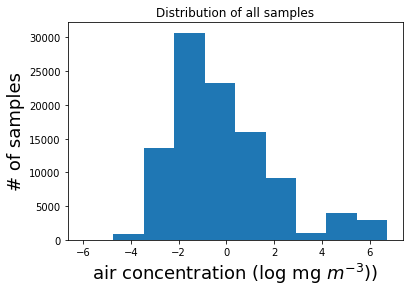

In [160]:
plt.hist((osha['log_mgm3']))
plt.title("Distribution of all samples")
plt.xlabel('air concentration (log mg $m^{-3})$)', size=18)
plt.ylabel('# of samples', size=18)

### Opera abiotic properties ONLY

In [161]:
opera = pd.read_csv('../../data/osha/chemical_metadata/opera2_physical.csv')
opera

,PREFERRED_NAME,MoleculeID,LogP_pred,MP_pred,BP_pred,LogVP_pred,LogWS_pred,LogHL_pred,RT_pred,LogKOA_pred,LogD55_pred,LogD74_pred,LogOH_pred,LogKoc_pred
0,"1,1,1,2-Tetrafluoroethane",DTXSID1021324,0.827040,-102.840618,-22.605931,3.539329,-2.918477,-1.308825,1.077754,0.036410,0.827040,0.827040,-14.241688,1.602622
1,"1,1,1-Trichloro-2,2,2-trifluoroethane",DTXSID5027148,2.577394,-15.002823,48.806711,2.765054,-2.226180,-0.825878,11.526084,2.294088,2.577394,2.577394,-15.276176,1.861776
2,"1,2-Difluoro-1,1,2,2-tetrachloroethane",DTXSID5026091,3.042323,24.586119,91.183236,1.878533,-3.075882,-0.782740,12.076823,3.710297,3.042323,3.042323,-14.523127,1.994880
3,"1,1,2,2-Tetrachloroethane",DTXSID7021318,2.350099,-39.864348,147.582052,0.862776,-1.754303,-3.300416,10.683509,3.464204,2.350099,2.350099,-12.884900,1.894347
4,"1,1,2-Trichloro-1,2,2-trifluoroethane",DTXSID6021377,2.966338,-44.225351,50.560073,2.682974,-2.994329,-1.081953,8.322817,2.818690,2.966338,2.966338,-15.292594,1.861775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,4-Vinyl-1-cyclohexene dioxide,DTXSID0020604,0.670876,75.401822,221.813643,-1.583812,-0.246298,-4.695892,6.542498,4.306213,0.670876,0.670876,-10.711082,1.762055
729,"1,1-Dichloroethylene",DTXSID8021438,2.146029,-92.054831,41.134842,2.521820,-1.435674,-2.074198,0.000000,2.597997,2.146029,2.146029,-10.958900,1.780304
730,Oxamyl,DTXSID6021086,-0.537842,100.495968,306.162430,-3.848174,-0.203799,-9.882354,2.713181,9.225506,-0.540338,-0.537873,-11.234750,1.099346
731,Warfarin,DTXSID5023742,2.688832,162.602197,398.372135,-7.143559,-4.253120,-8.942250,16.801856,10.660081,2.688832,2.688832,-10.475345,2.965329


In [162]:
from sklearn.preprocessing import scale

opera = opera.drop(columns=['MoleculeID'])
#chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
opera.columns = [x.lower() for x in opera.columns]
opera_cols =  opera.columns[1:]
opera_s = opera.copy()
opera_s[opera_cols] =  scale(opera_s[opera_cols])  # center and scale opera predictors

In [163]:
opera_s = opera_s.drop(columns=['logkoa_pred','mp_pred', 'logd55_pred','logd74_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')
opera_cols_med = ['log octanol-water partition coefficient','boiling point', 'log vapor pressure', 'log water solubility', "log henry's law constant",
                 'HPLC retention time', 'log OH rate constant', 'log soil adsorption coefficient']


chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=opera_cols)  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 87)

In [164]:
#from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(interaction_only=True, include_bias=False)
#opera_s_ints = poly.fit_transform(osha_enc[opera_cols])
#opera_cols_ints = poly.get_feature_names()[10:]
#opera_interactions = pd.DataFrame(opera_s_ints[:,10:], columns=opera_cols_ints, index=osha_enc.index)
#osha_enc = osha_enc.join(opera_interactions)

In [165]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

#from sklearn.model_selection import train_test_split
#indexed_osha, indexed_osha_test = train_test_split(indexed_osha, test_size=0.1, random_state=5757)  # training/test dataset split completely random

#indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
#indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

substances = indexed_osha['preferred_name'].unique()
test_substances = pd.Series(substances).sample(frac=0.1,random_state=13480)
indexed_osha_test = indexed_osha[indexed_osha['preferred_name'].isin(test_substances)]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(test_substances))]
len(indexed_osha_test)/len(indexed_osha)

0.08942092738155333

In [166]:
preds = indexed_osha[opera_cols]
npreds = len(opera_cols)

conc_shared = shared(indexed_osha.log_mgm3.values)
preds_shared = shared(preds.as_matrix())
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)


with pm.Model() as osha_physical:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    
    overall_int = pm.StudentT("overall_int", 1, mu=0,
                          sigma=10)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)# + overall_int
    sampling_error = pm.HalfCauchy('sampling_error',beta=25)
    #θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Normal(
        'likelihood',
        mu = μ,
        sigma = sampling_error,
        observed=conc_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


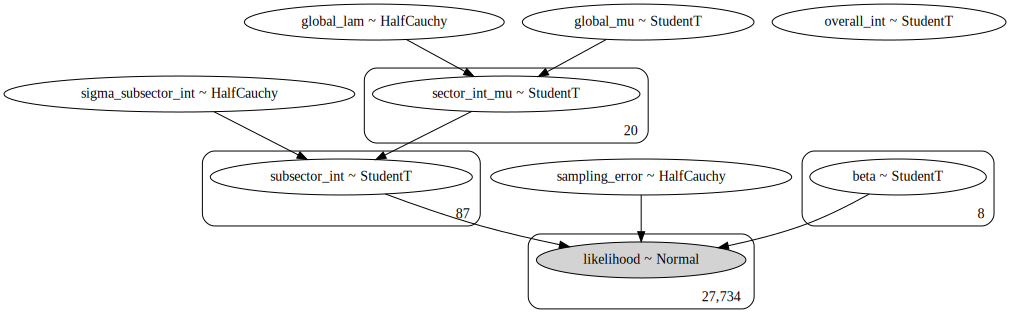

In [167]:
pm.model_to_graphviz(osha_physical)

In [168]:
with osha_physical:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple seq

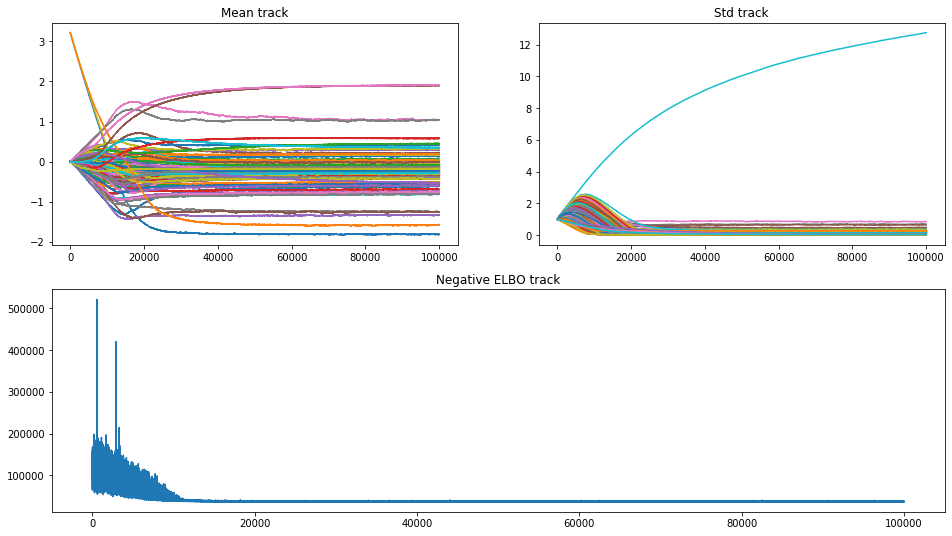

In [169]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

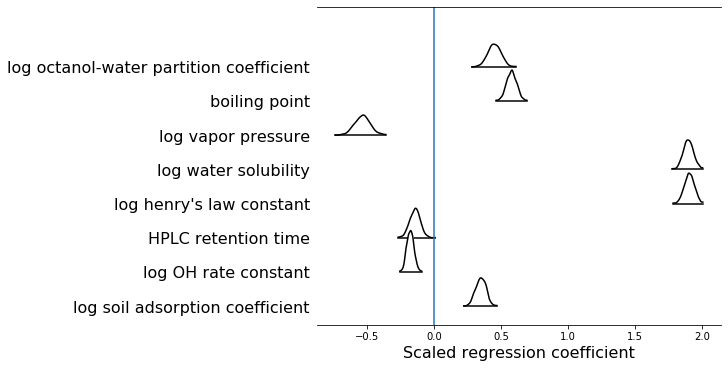

In [170]:
fig, axes = pm.forestplot(fit.sample(1000), kind='ridgeplot', var_names=['beta'], ridgeplot_overlap=3, colors='white', figsize=(10,5))
fig.axes[0].set_yticklabels(opera_cols_med[::-1], size=16)
fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
plt.axvline(x=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


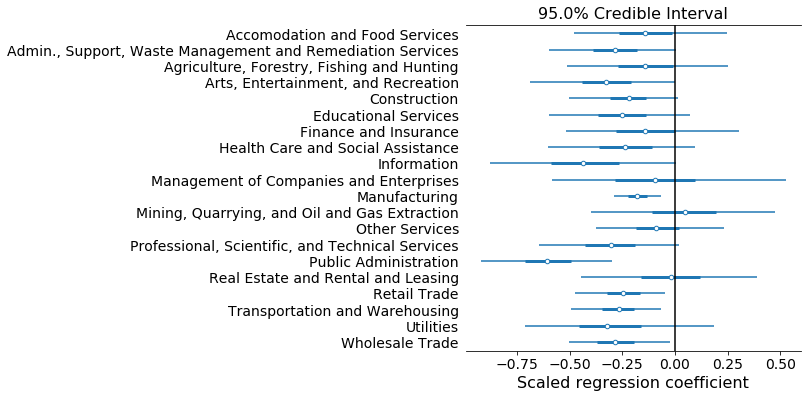

In [171]:
sector_index.loc[1,'sector_name'] = "Admin., Support, Waste Management and Remediation Services"  # make sector label shorter
fig, axes = pm.forestplot(fit.sample(1000), var_names=['sector_int_mu'], credible_interval=0.95)
fig.axes[0].set_yticklabels(sector_index['sector_name'][::-1])
fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
plt.axvline(x=0, color='black')

In [172]:
#fig, axs = pm.forestplot(fit.sample(1000), var_names=['subsector_int'], figsize=(8,18.5), credible_interval=0.95)
#fig.axes[0].set_yticklabels(sector_subsector_index['subsector_name'][::-1])
#fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
#plt.axvline(x=0, color='black')

## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [173]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_physical)
avg_predictions = ppc['likelihood'].mean(axis=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:06<00:00, 76.64it/s]


#### Regression accuracy metrics

In [193]:
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(indexed_osha['log_mgm3'], avg_predictions)
rmse = np.sqrt(mean_squared_error(avg_predictions, indexed_osha['log_mgm3']))
print('Training r2: {:.2f}'.format(r2))
print('Training RMSE: {:.2f}'.format(rmse))

Training r2: 0.58
Training RMSE: 0.91


In [175]:
null_predictions = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha['log_mgm3']))
null_r2 = r2_score(indexed_osha['log_mgm3'], null_predictions, )
print('Null model r2: {:.2f}'.format(null_r2))

Null model r2: 0.00


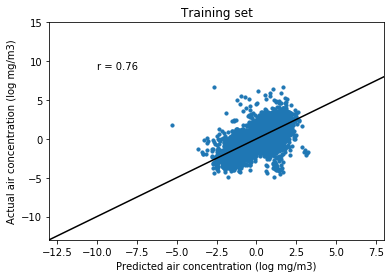

In [176]:
r = np.corrcoef(indexed_osha['log_mgm3'], avg_predictions)[0,1]
plt.scatter(avg_predictions, indexed_osha['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title('Training set')
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

#### Actual vs predicted subsector mean air concentration

In [177]:
subsector_means = indexed_osha[['log_mgm3', 'index_ss']].copy()
subsector_means['conc_predicted'] = avg_predictions
subsector_means = subsector_means.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]

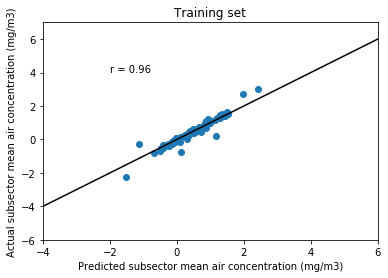

In [178]:
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]
plt.scatter( subsector_means['conc_predicted'], subsector_means['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Training set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()

In [179]:
residuals_train = indexed_osha['log_mgm3'] - avg_predictions

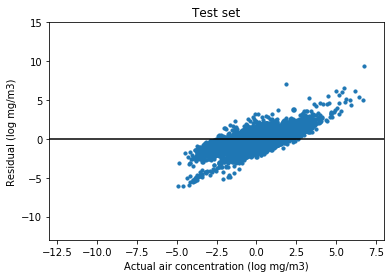

In [180]:
plt.scatter(indexed_osha['log_mgm3'], residuals_train, s=10)
plt.axhline(0, color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set")
plt.xlabel('Actual air concentration (log mg/m3)')
plt.ylabel('Residual (log mg/m3)')
plt.show()

### Test set accuracy

In [181]:
preds_test = indexed_osha_test[opera_cols]
conc_shared.set_value(indexed_osha_test.log_mgm3.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_physical)
avg_predictions_test = ppc_test['likelihood'].mean(axis=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:05<00:00, 93.51it/s]


#### Classification accuracy metrics (test)

In [182]:
from sklearn.metrics import r2_score, mean_squared_error
r2_test = r2_score(indexed_osha_test['log_mgm3'], avg_predictions_test, )
rmse = np.sqrt(mean_squared_error(avg_predictions_test, indexed_osha_test['log_mgm3']))
print('Test r2: {:.2f}'.format(r2_test))
print('Test RMSE: {:.2f}'.format(rmse))

Test r2: 0.46
Test RMSE: 0.93


In [183]:
null_predictions_test = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha_test['log_mgm3']))
null_r2_test = r2_score(indexed_osha_test['log_mgm3'], null_predictions_test)
print('Null model test r2: {:.2f}'.format(null_r2_test))

Null model test r2: -140150788580273775581069395886080.00


In [184]:
test_mean = np.repeat(indexed_osha_test['log_mgm3'].mean(),
                                      repeats=len(indexed_osha_test['log_mgm3']))
test_mean_r2 = r2_score(test_mean, indexed_osha_test['log_mgm3'])
test_mean_rmse = np.sqrt(mean_squared_error(test_mean, indexed_osha_test['log_mgm3']))
print('r2 using mean of test data: {:.2f}'.format(test_mean_r2))
print('RMSE using mean of test data: {:.2f}'.format(test_mean_rmse))

r2 using mean of test data: 0.00
RMSE using mean of test data: 1.27


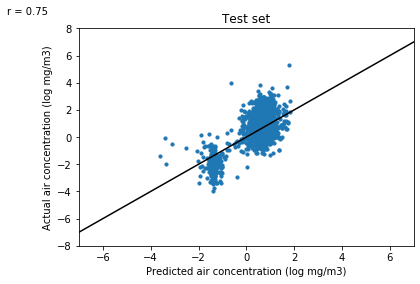

In [192]:
r = np.corrcoef(indexed_osha_test['log_mgm3'], avg_predictions_test)[0,1]
plt.scatter(avg_predictions_test, indexed_osha_test['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-7,7])
plt.ylim([-8,8])
plt.title("Test set")
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

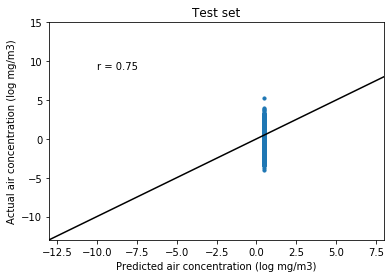

In [186]:
r = np.corrcoef(indexed_osha_test['log_mgm3'], avg_predictions_test)[0,1]
plt.scatter(null_predictions_test, indexed_osha_test['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set")
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

In [187]:
residuals_test = indexed_osha_test['log_mgm3'] - avg_predictions_test

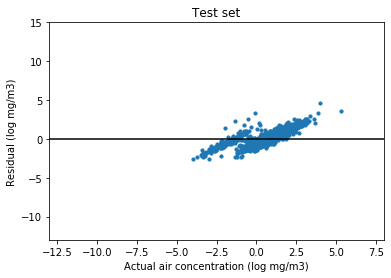

In [188]:
plt.scatter(indexed_osha_test['log_mgm3'], residuals_test, s=10)
plt.axhline(0, color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set")
plt.xlabel('Actual air concentration (log mg/m3)')
plt.ylabel('Residual (log mg/m3)')
plt.show()

#### Actual vs predicted subsector mean air concentration (test)

In [189]:
subsector_means_test = indexed_osha_test[['log_mgm3', 'index_ss']].copy()
subsector_means_test['conc_predicted'] = avg_predictions_test
subsector_means_test = subsector_means_test.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points

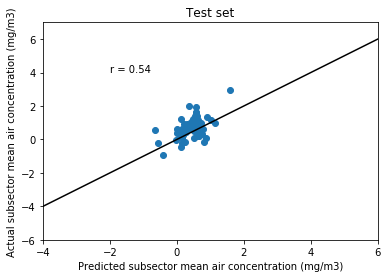

In [190]:
r = np.corrcoef(subsector_means_test['log_mgm3'], subsector_means_test['conc_predicted'])[0,1]
plt.scatter( subsector_means_test['conc_predicted'], subsector_means_test['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Test set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()

## Opera abiotic properties + biological properties

In [152]:
opera = pd.read_csv('../../data/osha/chemical_metadata/opera2_physical_biological.csv')

In [153]:
from sklearn.preprocessing import scale

opera = opera.drop(columns=['MoleculeID'])
#chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
opera.columns = [x.lower() for x in opera.columns]
opera_cols =  opera.columns[1:]
opera_s = opera.copy()
center_scale_cols = opera_cols.tolist().copy()
center_scale_cols.remove('readybiodeg_pred')
opera_s[center_scale_cols] =  scale(opera_s[center_scale_cols])  # center and scale opera predictors

In [154]:
#opera_s = opera_s.drop(columns=['octanol_air_partition_coeff_logkoa_opera_pred','melting_point_degc_opera_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')

chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=opera_cols)  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 87)

In [155]:
#from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(interaction_only=True, include_bias=False)
#opera_s_ints = poly.fit_transform(osha_enc[opera_cols])
#opera_cols_ints = poly.get_feature_names()[10:]
#opera_interactions = pd.DataFrame(opera_s_ints[:,10:], columns=opera_cols_ints, index=osha_enc.index)
#osha_enc = osha_enc.join(opera_interactions)

In [156]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

#from sklearn.model_selection import train_test_split
#indexed_osha, indexed_osha_test = train_test_split(indexed_osha, test_size=0.1, random_state=5757)  # training/test dataset split completely random

indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

In [157]:
preds = indexed_osha[opera_cols]
npreds = len(opera_cols)

conc_shared = shared(indexed_osha.log_mgm3.values)
preds_shared = shared(preds.as_matrix())
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)


with pm.Model() as osha_physical_biological:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    sampling_error = pm.HalfCauchy('sampling_error',beta=25)
    #θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Normal(
        'likelihood',
        mu = μ,
        sigma = sampling_error,
        observed=conc_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [158]:
#pm.model_to_graphviz(osha_physical_biological)

In [159]:
with osha_physical_biological:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = 55,495: 100%|██████████| 100000/100000 [03:51<00:00, 431.89it/s]
Finished [100%]: Average Loss = 55,495


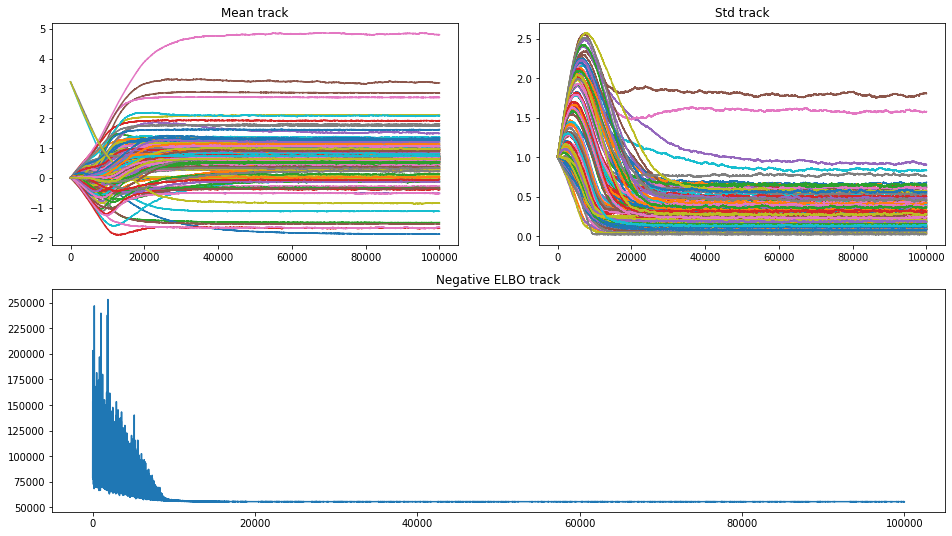

In [160]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

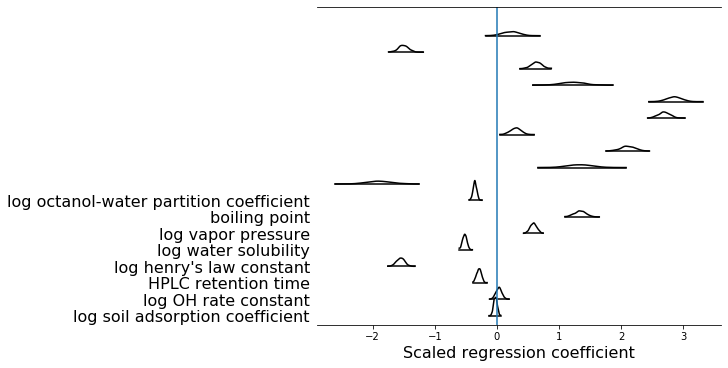

In [161]:
fig, axes = pm.forestplot(fit.sample(1000), kind='ridgeplot', var_names=['beta'], ridgeplot_overlap=3, colors='white', figsize=(10,5))
fig.axes[0].set_yticklabels(opera_cols_med[::-1], size=16)
fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
plt.axvline(x=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


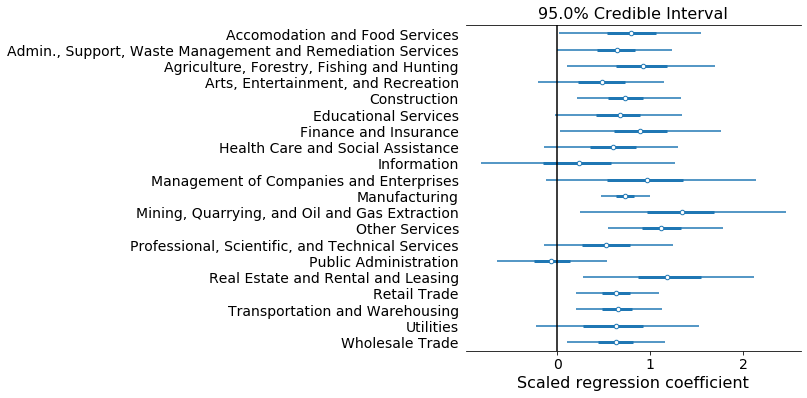

In [162]:
sector_index.loc[1,'sector_name'] = "Admin., Support, Waste Management and Remediation Services"  # make sector label shorter
fig, axes = pm.forestplot(fit.sample(1000), var_names=['sector_int_mu'], credible_interval=0.95)
fig.axes[0].set_yticklabels(sector_index['sector_name'][::-1])
fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
plt.axvline(x=0, color='black')

In [163]:
#fig, axs = pm.forestplot(fit.sample(1000), var_names=['subsector_int'], figsize=(8,18.5), credible_interval=0.95)
#fig.axes[0].set_yticklabels(sector_subsector_index['subsector_name'][::-1])
#fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
#plt.axvline(x=0, color='black')

## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [164]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_physical_biological)
avg_predictions = ppc['likelihood'].mean(axis=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:06<00:00, 75.36it/s]


#### Classification accuracy metrics

In [87]:
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(avg_predictions, indexed_osha['log_mgm3'])
rmse = np.sqrt(mean_squared_error(avg_predictions, indexed_osha['log_mgm3']))
print('Training r2: {:.2f}'.format(r2))
print('Training RMSE: {:.2f}'.format(rmse))

Training r2: 0.28
Training RMSE: 2.09


In [65]:
null_predictions = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha['log_mgm3']))
null_r2 = r2_score(null_predictions, indexed_osha['log_mgm3'])
print('Null model r2: {:.2f}'.format(null_r2))

Null model r2: -53033544028500171951701915336704.00


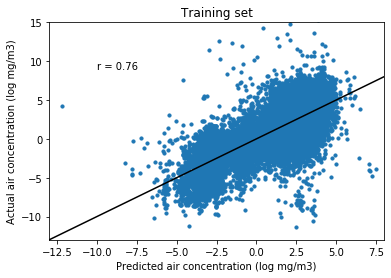

In [66]:
r = np.corrcoef(indexed_osha['log_mgm3'], avg_predictions)[0,1]
plt.scatter(avg_predictions, indexed_osha['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title('Training set')
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

#### Actual vs predicted subsector mean air concentration

In [67]:
subsector_means = indexed_osha[['log_mgm3', 'index_ss']].copy()
subsector_means['conc_predicted'] = avg_predictions
subsector_means = subsector_means.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]

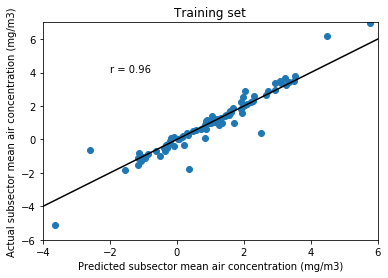

In [68]:
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]
plt.scatter( subsector_means['conc_predicted'], subsector_means['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Training set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()

In [83]:
residuals_train = indexed_osha['log_mgm3'] - avg_predictions

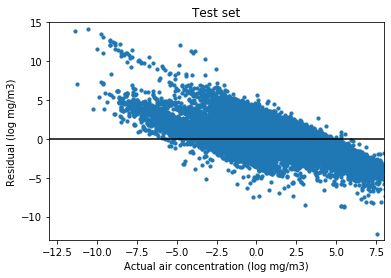

In [84]:
plt.scatter(indexed_osha['log_mgm3'], residuals_train, s=10)
plt.axhline(0, color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set")
plt.xlabel('Actual air concentration (log mg/m3)')
plt.ylabel('Residual (log mg/m3)')
plt.show()

### Test set accuracy

In [69]:
preds_test = indexed_osha_test[opera_cols]
conc_shared.set_value(indexed_osha_test.log_mgm3.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_physical)
avg_predictions_test = ppc_test['likelihood'].mean(axis=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:05<00:00, 91.37it/s]


#### Classification accuracy metrics (test)

In [89]:
from sklearn.metrics import r2_score, mean_squared_error
r2_test = r2_score(avg_predictions_test, indexed_osha_test['log_mgm3'])
rmse = np.sqrt(mean_squared_error(avg_predictions_test, indexed_osha_test['log_mgm3']))
print('Test r2: {:.2f}'.format(r2_test))
print('Training RMSE: {:.2f}'.format(rmse))

Test r2: -0.76
Training RMSE: 2.16


In [71]:
null_predictions_test = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha_test['log_mgm3']))
null_r2_test = r2_score(null_predictions_test, indexed_osha_test['log_mgm3'])
print('Null model test r2: {:.2f}'.format(null_r2_test))

Null model test r2: -185766300288952737827621217239040.00


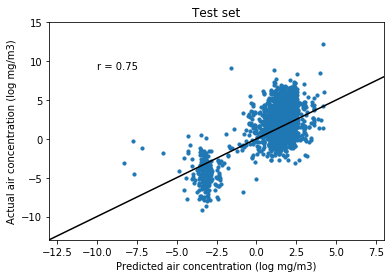

In [72]:
r = np.corrcoef(indexed_osha_test['log_mgm3'], avg_predictions_test)[0,1]
plt.scatter(avg_predictions_test, indexed_osha_test['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set")
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

In [80]:
residuals_test =  indexed_osha_test['log_mgm3'] - avg_predictions_test

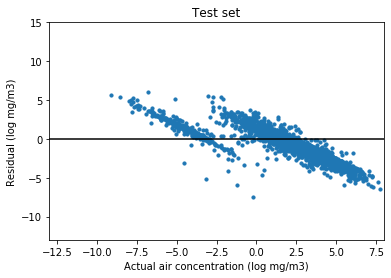

In [78]:
plt.scatter(indexed_osha_test['log_mgm3'], residuals_test, s=10)
plt.axhline(0, color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set")
plt.xlabel('Actual air concentration (log mg/m3)')
plt.ylabel('Residual (log mg/m3)')
plt.show()

#### Actual vs predicted subsector mean air concentration (test)

In [36]:
subsector_means_test = indexed_osha_test[['log_mgm3', 'index_ss']].copy()
subsector_means_test['conc_predicted'] = avg_predictions_test
subsector_means_test = subsector_means_test.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points

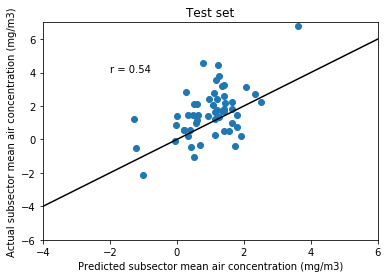

In [37]:
r = np.corrcoef(subsector_means_test['log_mgm3'], subsector_means_test['conc_predicted'])[0,1]
plt.scatter( subsector_means_test['conc_predicted'], subsector_means_test['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Test set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()

# Opera abiotic + structural

In [151]:
opera = pd.read_csv('../../data/osha/chemical_metadata/opera2_physical_structural.csv')

In [102]:
from sklearn.preprocessing import scale

opera = opera.drop(columns=['MoleculeID'])
#chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
opera.columns = [x.lower() for x in opera.columns]
opera_cols =  opera.columns[1:]
opera_s = opera.copy()
center_scale_cols =  [x for x in opera_cols.tolist() if not x.startswith('nb') and not x.startswith('nd')]
opera_s[center_scale_cols] =  scale(opera_s[center_scale_cols])  # center and scale opera predictors

In [103]:
#opera_s = opera_s.drop(columns=['octanol_air_partition_coeff_logkoa_opera_pred','melting_point_degc_opera_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')

chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=opera_cols)  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 87)

In [104]:
#from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(interaction_only=True, include_bias=False)
#opera_s_ints = poly.fit_transform(osha_enc[opera_cols])
#opera_cols_ints = poly.get_feature_names()[10:]
#opera_interactions = pd.DataFrame(opera_s_ints[:,10:], columns=opera_cols_ints, index=osha_enc.index)
#osha_enc = osha_enc.join(opera_interactions)

In [105]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

#from sklearn.model_selection import train_test_split
#indexed_osha, indexed_osha_test = train_test_split(indexed_osha, test_size=0.1, random_state=5757)  # training/test dataset split completely random

indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

In [106]:
preds = indexed_osha[opera_cols]
npreds = len(opera_cols)

conc_shared = shared(indexed_osha.log_mgm3.values)
preds_shared = shared(preds.as_matrix())
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)

with pm.Model() as osha_physical_structural:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    sampling_error = pm.HalfCauchy('sampling_error',beta=25)
    #θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Normal(
        'likelihood',
        mu = μ,
        sigma = sampling_error,
        observed=conc_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


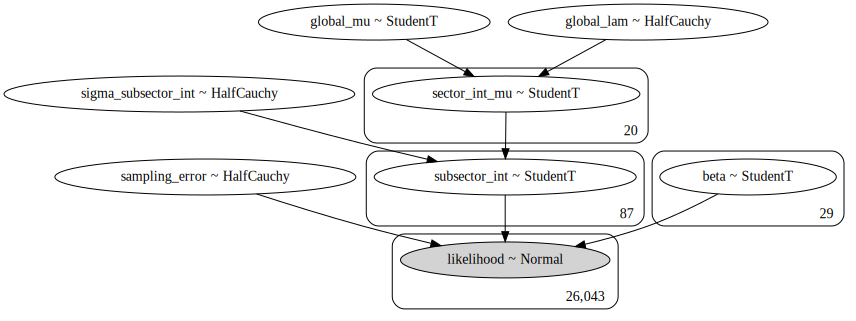

In [107]:
#pm.model_to_graphviz(osha_physical_structural)

In [108]:
with osha_physical_structural:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple seq

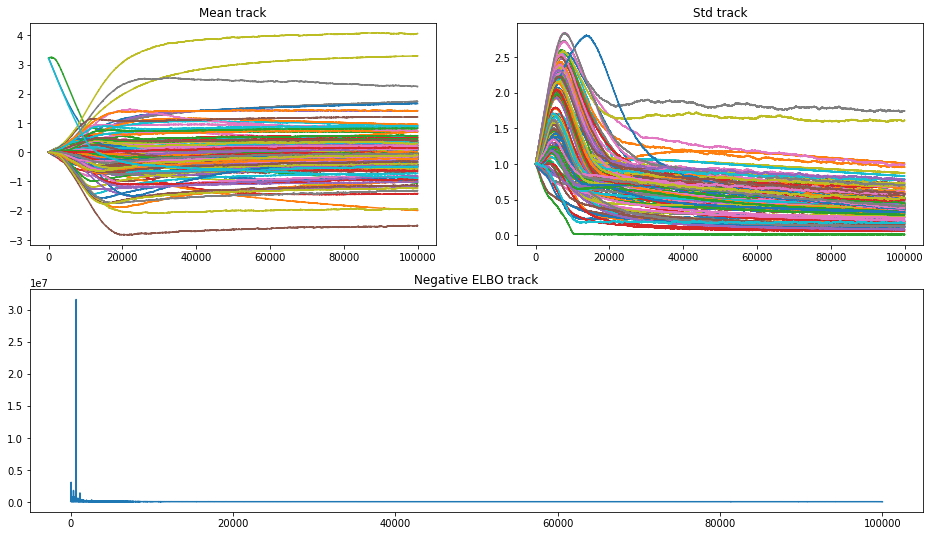

In [109]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

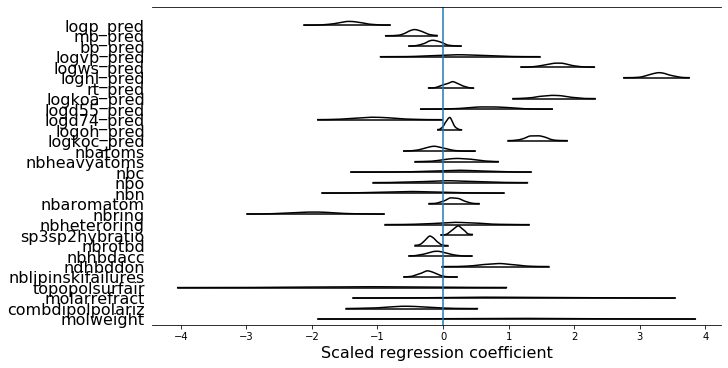

In [110]:
fig, axes = pm.forestplot(fit.sample(1000), kind='ridgeplot', var_names=['beta'], ridgeplot_overlap=3, colors='white', figsize=(10,5))
fig.axes[0].set_yticklabels(opera_cols[::-1], size=16)
fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
plt.axvline(x=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


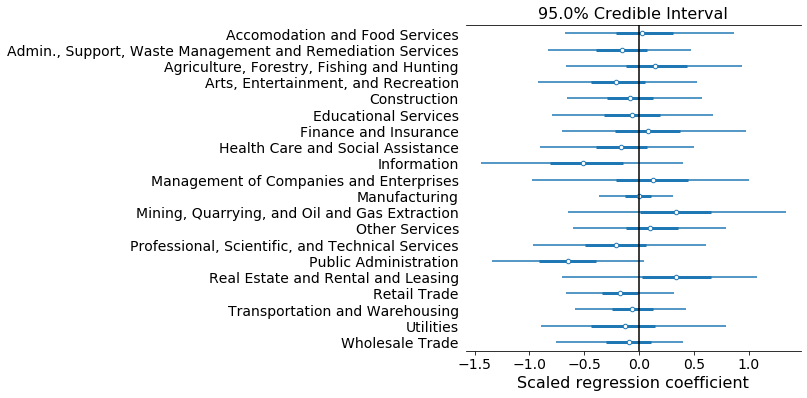

In [111]:
sector_index.loc[1,'sector_name'] = "Admin., Support, Waste Management and Remediation Services"  # make sector label shorter
fig, axes = pm.forestplot(fit.sample(1000), var_names=['sector_int_mu'], credible_interval=0.95)
fig.axes[0].set_yticklabels(sector_index['sector_name'][::-1])
fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
plt.axvline(x=0, color='black')

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


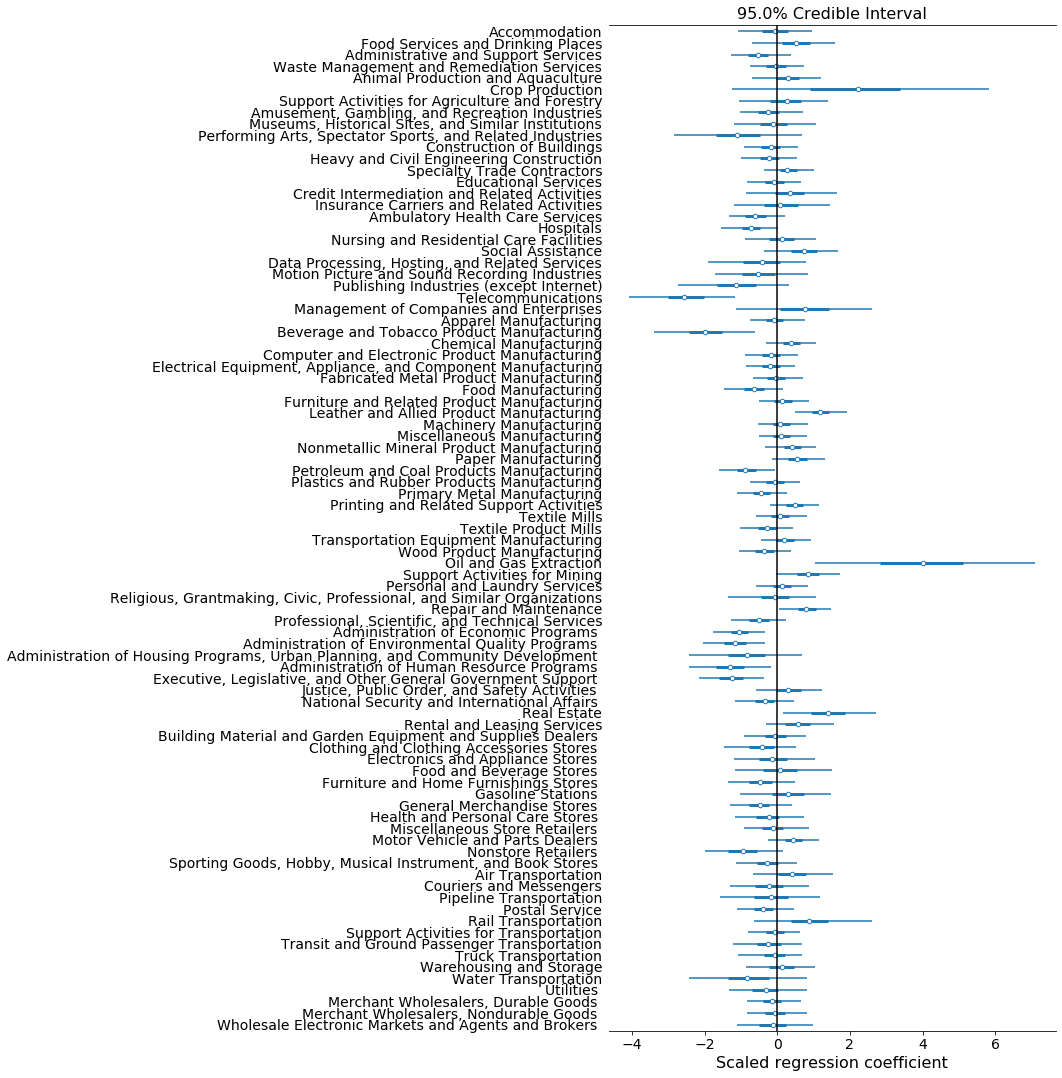

In [112]:
#fig, axs = pm.forestplot(fit.sample(1000), var_names=['subsector_int'], figsize=(8,18.5), credible_interval=0.95)
#fig.axes[0].set_yticklabels(sector_subsector_index['subsector_name'][::-1])
#fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
#plt.axvline(x=0, color='black')

## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [113]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_physical_structural)
avg_predictions = ppc['likelihood'].mean(axis=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:06<00:00, 76.99it/s]


#### Classification accuracy metrics

In [114]:
from sklearn.metrics import r2_score
r2 = r2_score(avg_predictions, indexed_osha['log_mgm3'])
print('Training r2: {:.2f}'.format(r2))

Training r2: 0.39


In [115]:
null_predictions = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha['log_mgm3']))
null_r2 = r2_score(null_predictions, indexed_osha['log_mgm3'])
print('Null model r2: {:.2f}'.format(null_r2))

Null model r2: 0.00


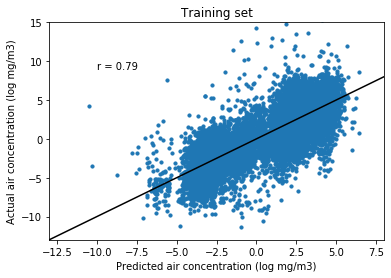

In [116]:
r = np.corrcoef(indexed_osha['log_mgm3'], avg_predictions)[0,1]
plt.scatter(avg_predictions, indexed_osha['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title('Training set')
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

#### Actual vs predicted subsector mean air concentration

In [117]:
subsector_means = indexed_osha[['log_mgm3', 'index_ss']].copy()
subsector_means['conc_predicted'] = avg_predictions
subsector_means = subsector_means.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]

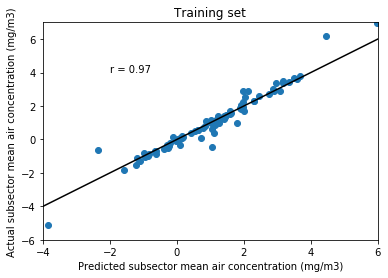

In [118]:
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]
plt.scatter( subsector_means['conc_predicted'], subsector_means['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Training set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()

### Test set accuracy

In [119]:
preds_test = indexed_osha_test[opera_cols]
conc_shared.set_value(indexed_osha_test.log_mgm3.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_physical_structural)
avg_predictions_test = ppc_test['likelihood'].mean(axis=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:05<00:00, 89.19it/s]


#### Classification accuracy metrics (test)

In [120]:
from sklearn.metrics import r2_score
r2_test = r2_score(avg_predictions_test, indexed_osha_test['log_mgm3'])
print('Test r2: {:.2f}'.format(r2_test))

Test r2: 0.32


In [121]:
null_predictions_test = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha_test['log_mgm3']))
null_r2_test = r2_score(null_predictions_test, indexed_osha_test['log_mgm3'])
print('Null model test r2: {:.2f}'.format(null_r2_test))

Null model test r2: -211057365740480434679542485876736.00


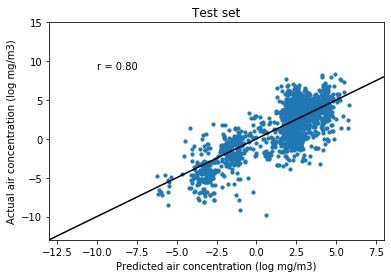

In [122]:
r = np.corrcoef(indexed_osha_test['log_mgm3'], avg_predictions_test)[0,1]
plt.scatter(avg_predictions_test, indexed_osha_test['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set")
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

#### Actual vs predicted subsector mean air concentration (test)

In [123]:
subsector_means_test = indexed_osha_test[['log_mgm3', 'index_ss']].copy()
subsector_means_test['conc_predicted'] = avg_predictions_test
subsector_means_test = subsector_means_test.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points

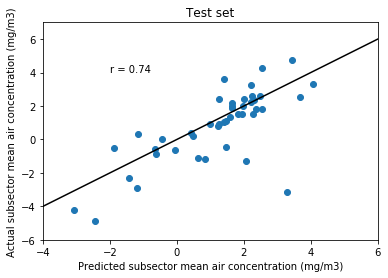

In [124]:
r = np.corrcoef(subsector_means_test['log_mgm3'], subsector_means_test['conc_predicted'])[0,1]
plt.scatter( subsector_means_test['conc_predicted'], subsector_means_test['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Test set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()

# Opera abiotic + biotic + structural

In [149]:
opera = pd.read_csv('../../data/osha/chemical_metadata/opera2_all.csv')

In [126]:
from sklearn.preprocessing import scale

opera = opera.drop(columns=['MoleculeID'])
#chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
opera.columns = [x.lower() for x in opera.columns]
opera_cols =  opera.columns[1:]
opera_s = opera.copy()
center_scale_cols =  [x for x in opera_cols.tolist() if not x.startswith('nb') and not x.startswith('nd')]
center_scale_cols.remove('readybiodeg_pred')
opera_s[center_scale_cols] =  scale(opera_s[center_scale_cols])  # center and scale opera predictors

In [127]:
#opera_s = opera_s.drop(columns=['octanol_air_partition_coeff_logkoa_opera_pred','melting_point_degc_opera_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')

chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=opera_cols)  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 87)

In [129]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

#from sklearn.model_selection import train_test_split
#indexed_osha, indexed_osha_test = train_test_split(indexed_osha, test_size=0.1, random_state=5757)  # training/test dataset split completely random

indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

In [130]:
preds = indexed_osha[opera_cols]
npreds = len(opera_cols)

conc_shared = shared(indexed_osha.log_mgm3.values)
preds_shared = shared(preds.as_matrix())
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)

with pm.Model() as osha_all:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    sampling_error = pm.HalfCauchy('sampling_error',beta=25)
    #θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Normal(
        'likelihood',
        mu = μ,
        sigma = sampling_error,
        observed=conc_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


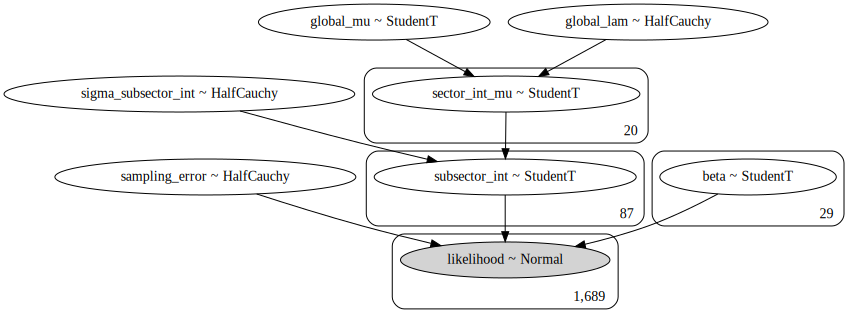

In [131]:
#pm.model_to_graphviz(osha_all)

In [132]:
with osha_all:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple seq

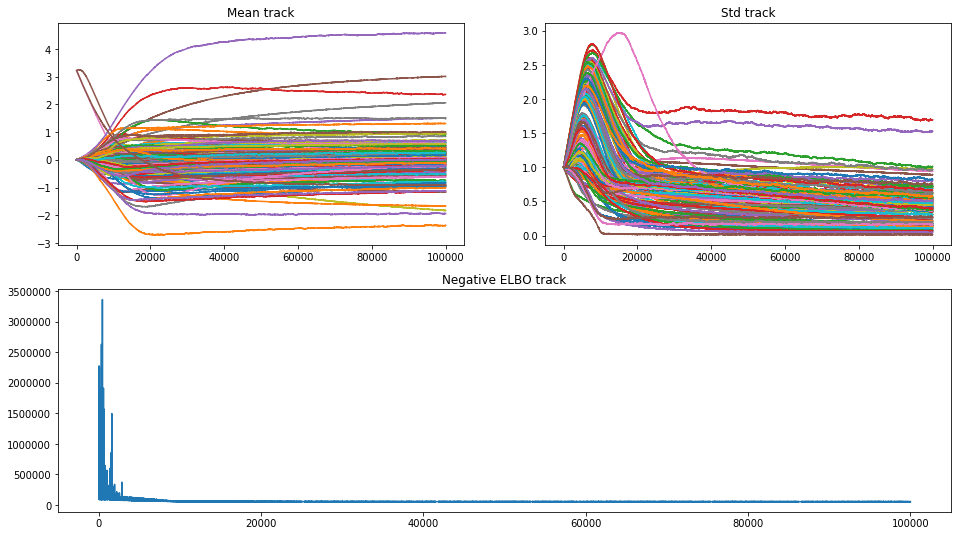

In [133]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

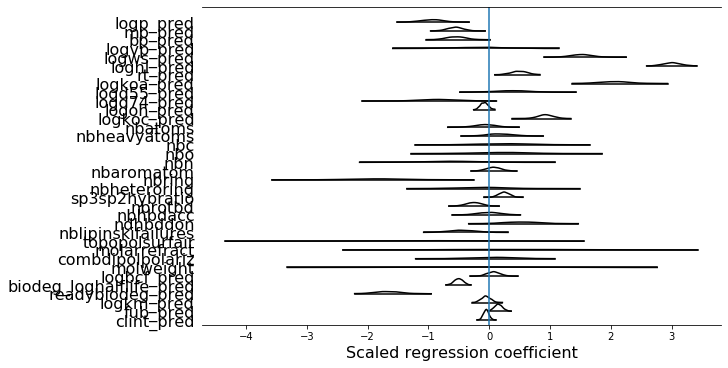

In [134]:
fig, axes = pm.forestplot(fit.sample(1000), kind='ridgeplot', var_names=['beta'], ridgeplot_overlap=3, colors='white', figsize=(10,5))
fig.axes[0].set_yticklabels(opera_cols[::-1], size=16)
fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
plt.axvline(x=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


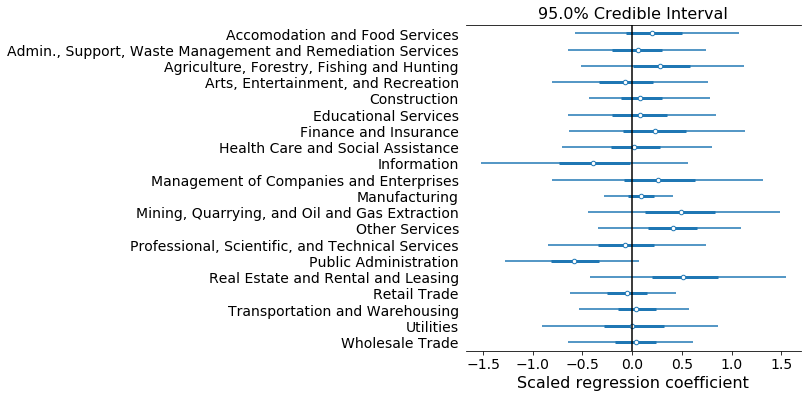

In [135]:
sector_index.loc[1,'sector_name'] = "Admin., Support, Waste Management and Remediation Services"  # make sector label shorter
fig, axes = pm.forestplot(fit.sample(1000), var_names=['sector_int_mu'], credible_interval=0.95)
fig.axes[0].set_yticklabels(sector_index['sector_name'][::-1])
fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
plt.axvline(x=0, color='black')

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


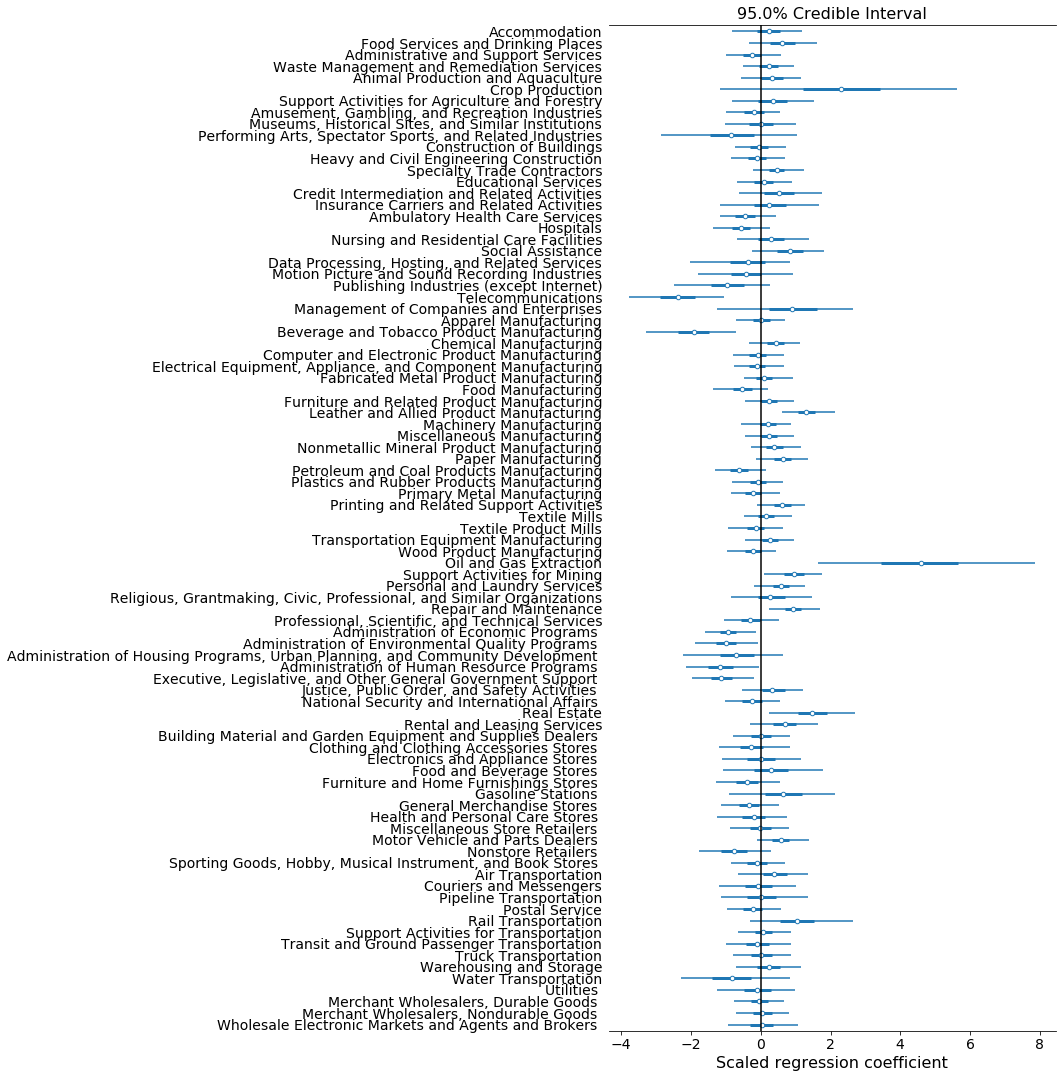

In [136]:
#fig, axs = pm.forestplot(fit.sample(1000), var_names=['subsector_int'], figsize=(8,18.5), credible_interval=0.95)
#fig.axes[0].set_yticklabels(sector_subsector_index['subsector_name'][::-1])
#fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
#plt.axvline(x=0, color='black')

## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [137]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_all)
avg_predictions = ppc['likelihood'].mean(axis=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:06<00:00, 80.01it/s]


#### Classification accuracy metrics

In [138]:
from sklearn.metrics import r2_score
r2 = r2_score(avg_predictions, indexed_osha['log_mgm3'])
print('Training r2: {:.2f}'.format(r2))

Training r2: 0.42


In [139]:
null_predictions = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha['log_mgm3']))
null_r2 = r2_score(null_predictions, indexed_osha['log_mgm3'])
print('Null model r2: {:.2f}'.format(null_r2))

Null model r2: 0.00


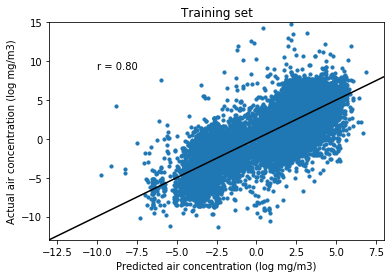

In [140]:
r = np.corrcoef(indexed_osha['log_mgm3'], avg_predictions)[0,1]
plt.scatter(avg_predictions, indexed_osha['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title('Training set')
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

#### Actual vs predicted subsector mean air concentration

In [141]:
subsector_means = indexed_osha[['log_mgm3', 'index_ss']].copy()
subsector_means['conc_predicted'] = avg_predictions
subsector_means = subsector_means.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]

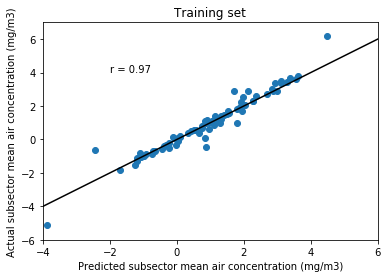

In [142]:
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]
plt.scatter( subsector_means['conc_predicted'], subsector_means['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Training set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()

### Test set accuracy

In [143]:
preds_test = indexed_osha_test[opera_cols]
conc_shared.set_value(indexed_osha_test.log_mgm3.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_all)
avg_predictions_test = ppc_test['likelihood'].mean(axis=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:05<00:00, 87.73it/s]


#### Classification accuracy metrics (test)

In [144]:
from sklearn.metrics import r2_score
r2_test = r2_score(avg_predictions_test, indexed_osha_test['log_mgm3'])
print('Test r2: {:.2f}'.format(r2_test))

Test r2: 0.38


In [145]:
null_predictions_test = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha_test['log_mgm3']))
null_r2_test = r2_score(null_predictions_test, indexed_osha_test['log_mgm3'])
print('Null model test r2: {:.2f}'.format(null_r2_test))

Null model test r2: -211057365740480434679542485876736.00


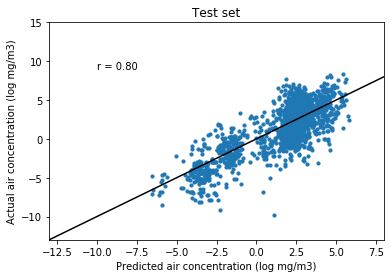

In [146]:
r = np.corrcoef(indexed_osha_test['log_mgm3'], avg_predictions_test)[0,1]
plt.scatter(avg_predictions_test, indexed_osha_test['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set")
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

#### Actual vs predicted subsector mean air concentration (test)

In [147]:
subsector_means_test = indexed_osha_test[['log_mgm3', 'index_ss']].copy()
subsector_means_test['conc_predicted'] = avg_predictions_test
subsector_means_test = subsector_means_test.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points

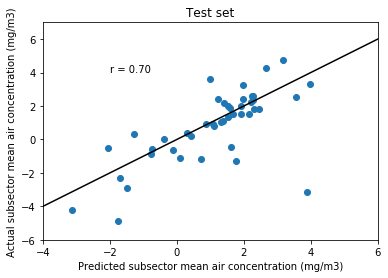

In [148]:
r = np.corrcoef(subsector_means_test['log_mgm3'], subsector_means_test['conc_predicted'])[0,1]
plt.scatter( subsector_means_test['conc_predicted'], subsector_means_test['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Test set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()

# Opera abiotic + biotic + structural + interactions

In [215]:
opera = pd.read_csv('../../data/osha/chemical_metadata/opera2_all.csv')

In [216]:
from sklearn.preprocessing import scale

opera = opera.drop(columns=['MoleculeID'])
#chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
opera.columns = [x.lower() for x in opera.columns]
opera_cols =  opera.columns[1:]
opera_s = opera.copy()
center_scale_cols =  [x for x in opera_cols.tolist() if not x.startswith('nb') and not x.startswith('nd')]
center_scale_cols.remove('readybiodeg_pred')
opera_s[center_scale_cols] =  scale(opera_s[center_scale_cols])  # center and scale opera predictors

In [217]:
#opera_s = opera_s.drop(columns=['octanol_air_partition_coeff_logkoa_opera_pred','melting_point_degc_opera_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')

chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=opera_cols)  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 87)

In [220]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True, include_bias=False)
opera_s_ints = poly.fit_transform(osha_enc[opera_cols])
opera_cols_ints = poly.get_feature_names()[len(opera_cols):]
opera_interactions = pd.DataFrame(opera_s_ints[:,len(opera_cols):], columns=opera_cols_ints, index=osha_enc.index)
osha_enc = osha_enc.join(opera_interactions)

In [221]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

#from sklearn.model_selection import train_test_split
#indexed_osha, indexed_osha_test = train_test_split(indexed_osha, test_size=0.1, random_state=5757)  # training/test dataset split completely random

indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

In [244]:
preds = indexed_osha[opera_cols+opera_cols_ints]
npreds = len(opera_cols+opera_cols_ints)

conc_shared = shared(indexed_osha.log_mgm3.values)
preds_shared = shared(preds.as_matrix())
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)

with pm.Model() as osha_all_ints:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    sampling_error = pm.HalfCauchy('sampling_error',beta=25)
    #θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Normal(
        'likelihood',
        mu = μ,
        sigma = sampling_error,
        observed=conc_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


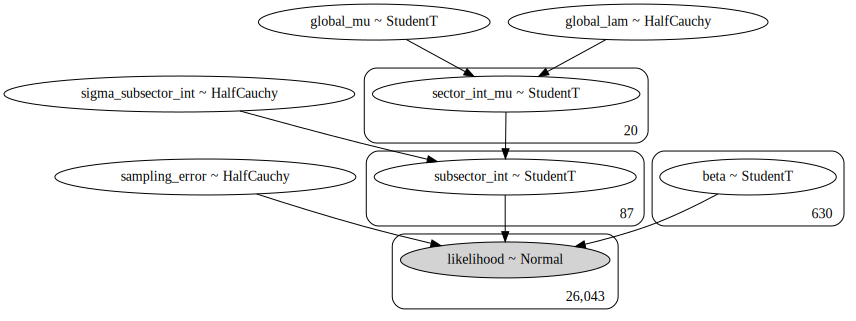

In [245]:
pm.model_to_graphviz(osha_all_ints)

In [246]:
with osha_all_ints:
    fr_advi = pm.ADVI()#pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(500000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 86,765: 100%|██████████| 100000/100000 [12:14<00:00, 136.23it/s]
Finished [100%]: Average Loss = 86,812


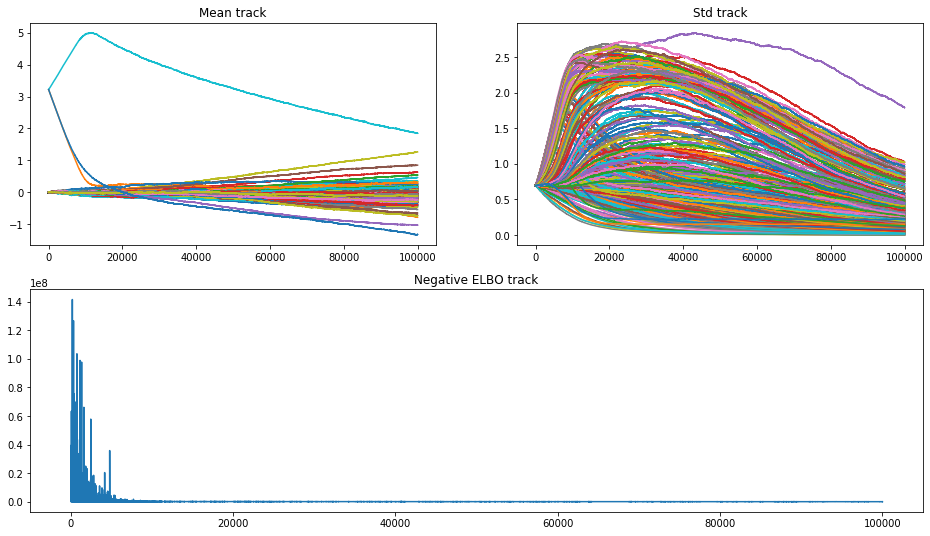

In [247]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

In [248]:
#fig, axes = pm.forestplot(fit.sample(1000), kind='ridgeplot', var_names=['beta'], ridgeplot_overlap=3, colors='white', figsize=(10,5))
#fig.axes[0].set_yticklabels(opera_cols[::-1], size=16)
#fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
#plt.axvline(x=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


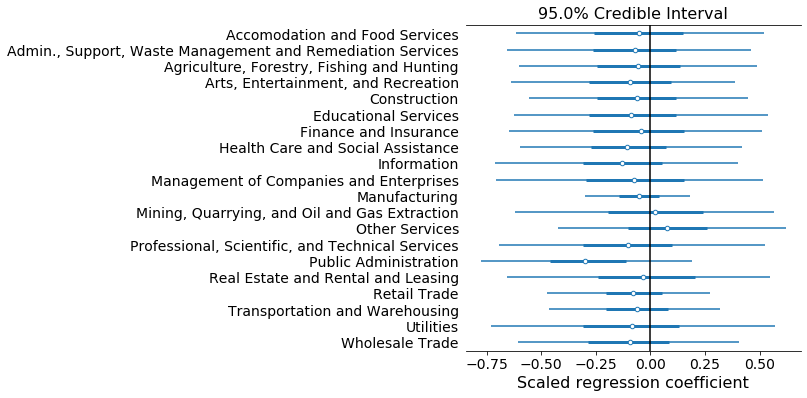

In [249]:
sector_index.loc[1,'sector_name'] = "Admin., Support, Waste Management and Remediation Services"  # make sector label shorter
fig, axes = pm.forestplot(fit.sample(1000), var_names=['sector_int_mu'], credible_interval=0.95)
fig.axes[0].set_yticklabels(sector_index['sector_name'][::-1])
fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
plt.axvline(x=0, color='black')

In [250]:
#fig, axs = pm.forestplot(fit.sample(1000), var_names=['subsector_int'], figsize=(8,18.5), credible_interval=0.95)
#fig.axes[0].set_yticklabels(sector_subsector_index['subsector_name'][::-1])
#fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
#plt.axvline(x=0, color='black')

## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [251]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_all_ints)
avg_predictions = ppc['likelihood'].mean(axis=0)

100%|██████████| 500/500 [00:09<00:00, 54.17it/s]


#### Classification accuracy metrics

In [252]:
from sklearn.metrics import r2_score
r2 = r2_score(avg_predictions, indexed_osha['log_mgm3'])
print('Training r2: {:.2f}'.format(r2))

Training r2: 0.56


In [253]:
null_predictions = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha['log_mgm3']))
null_r2 = r2_score(null_predictions, indexed_osha['log_mgm3'])
print('Null model r2: {:.2f}'.format(null_r2))

Null model r2: 0.00


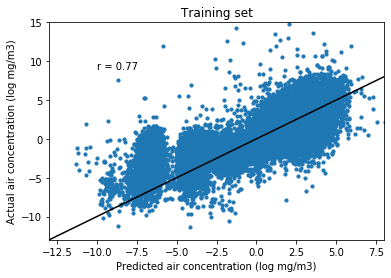

In [254]:
r = np.corrcoef(indexed_osha['log_mgm3'], avg_predictions)[0,1]
plt.scatter(avg_predictions, indexed_osha['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title('Training set')
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

#### Actual vs predicted subsector mean air concentration

In [255]:
subsector_means = indexed_osha[['log_mgm3', 'index_ss']].copy()
subsector_means['conc_predicted'] = avg_predictions
subsector_means = subsector_means.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]

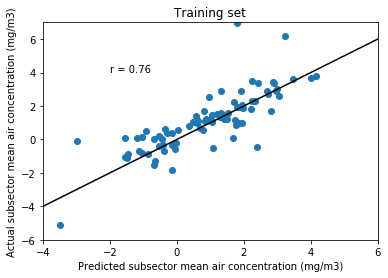

In [256]:
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]
plt.scatter( subsector_means['conc_predicted'], subsector_means['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Training set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()

### Test set accuracy

In [260]:
preds_test = indexed_osha_test[opera_cols+opera_cols_ints]
conc_shared.set_value(indexed_osha_test.log_mgm3.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_all_ints)
avg_predictions_test = ppc_test['likelihood'].mean(axis=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 500/500 [00:05<00:00, 84.77it/s]


#### Classification accuracy metrics (test)

In [261]:
from sklearn.metrics import r2_score
r2_test = r2_score(avg_predictions_test, indexed_osha_test['log_mgm3'])
print('Test r2: {:.2f}'.format(r2_test))

Test r2: 0.57


In [262]:
null_predictions_test = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha_test['log_mgm3']))
null_r2_test = r2_score(null_predictions_test, indexed_osha_test['log_mgm3'])
print('Null model test r2: {:.2f}'.format(null_r2_test))

Null model test r2: -211057365740480434679542485876736.00


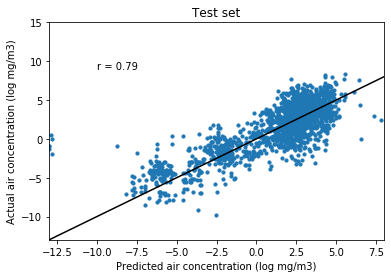

In [263]:
r = np.corrcoef(indexed_osha_test['log_mgm3'], avg_predictions_test)[0,1]
plt.scatter(avg_predictions_test, indexed_osha_test['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set")
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

#### Actual vs predicted subsector mean air concentration (test)

In [264]:
subsector_means_test = indexed_osha_test[['log_mgm3', 'index_ss']].copy()
subsector_means_test['conc_predicted'] = avg_predictions_test
subsector_means_test = subsector_means_test.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points

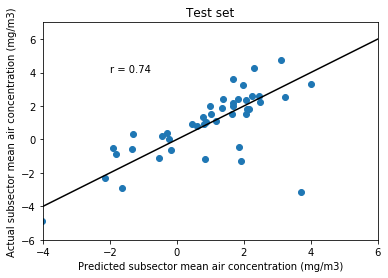

In [265]:
r = np.corrcoef(subsector_means_test['log_mgm3'], subsector_means_test['conc_predicted'])[0,1]
plt.scatter( subsector_means_test['conc_predicted'], subsector_means_test['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Test set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()

### Accuracy on new substances x workplace combinations in test set

In [111]:
train_combos =  indexed_osha['preferred_name'] + ' X ' + indexed_osha['subsector_name']
test_combos =  indexed_osha_test['preferred_name'] + ' X ' + indexed_osha_test['subsector_name']
train_combos.reset_index(drop=True, inplace=True)
test_combos.reset_index(drop=True, inplace=True)
test_unique = test_combos[~test_combos.isin(train_combos)].index
test_repeats = test_combos[test_combos.isin(train_combos)].index

In [116]:
novel_predictions_test = avg_predictions_test[test_unique]
repeat_predictions_test = avg_predictions_test[test_repeats]
from sklearn.metrics import r2_score
r2_test = r2_score(novel_predictions_test, indexed_osha_test.iloc[test_unique]['log_mgm3'])
r2_test_r = r2_score(repeat_predictions_test, indexed_osha_test.iloc[test_repeats]['log_mgm3'])
print('Test r2 (unique): {:.2f}'.format(r2_test))
print('Test r2 (repeat): {:.2f}'.format(r2_test_r))

Test r2 (unique): -0.39
Test r2 (repeat): 0.37


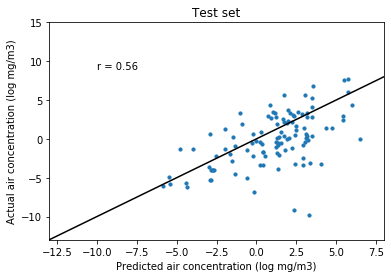

In [110]:
r = np.corrcoef(indexed_osha_test.iloc[test_unique]['log_mgm3'],novel_predictions_test)[0,1]
plt.scatter(novel_predictions_test, indexed_osha_test.iloc[test_unique]['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set unique combos")
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

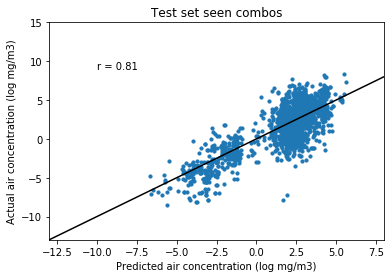

In [117]:
r = np.corrcoef(indexed_osha_test.iloc[test_repeats]['log_mgm3'],repeat_predictions_test)[0,1]
plt.scatter(repeat_predictions_test, indexed_osha_test.iloc[test_repeats]['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set seen combos")
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

# Opera abiotic + interactions

In [121]:
opera = pd.read_csv('../../data/osha/chemical_metadata/opera2_physical.csv')

In [122]:
from sklearn.preprocessing import scale

opera = opera.drop(columns=['MoleculeID'])
#chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
opera.columns = [x.lower() for x in opera.columns]
opera_cols =  opera.columns[1:]
opera_s = opera.copy()
opera_s[opera_cols] =  scale(opera_s[opera_cols])  # center and scale opera predictors

In [123]:
opera_s = opera_s.drop(columns=['logkoa_pred','mp_pred', 'logd55_pred','logd74_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')
opera_cols_med = ['log octanol-water partition coefficient','boiling point', 'log vapor pressure', 'log water solubility', "log henry's law constant",
                 'HPLC retention time', 'log OH rate constant', 'log soil adsorption coefficient']


chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=opera_cols)  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 87)

In [124]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True, include_bias=False)
opera_s_ints = poly.fit_transform(osha_enc[opera_cols])
opera_cols_ints = poly.get_feature_names()[len(opera_cols):]
opera_interactions = pd.DataFrame(opera_s_ints[:,len(opera_cols):], columns=opera_cols_ints, index=osha_enc.index)
osha_enc = osha_enc.join(opera_interactions)

In [125]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

#from sklearn.model_selection import train_test_split
#indexed_osha, indexed_osha_test = train_test_split(indexed_osha, test_size=0.1, random_state=5757)  # training/test dataset split completely random

#indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
#indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

substances = indexed_osha['preferred_name'].unique()
test_substances = pd.Series(substances).sample(frac=0.1,random_state=13480)
indexed_osha_test = indexed_osha[indexed_osha['preferred_name'].isin(test_substances)]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(test_substances))]
len(indexed_osha_test)/len(indexed_osha)

0.08942092738155333

In [126]:
preds = indexed_osha[opera_cols+opera_cols_ints]
npreds = len(opera_cols+opera_cols_ints)

conc_shared = shared(indexed_osha.log_mgm3.values)
preds_shared = shared(preds.as_matrix())
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)

with pm.Model() as osha_physical_ints:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    sampling_error = pm.HalfCauchy('sampling_error',beta=25)
    #θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Normal(
        'likelihood',
        mu = μ,
        sigma = sampling_error,
        observed=conc_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [127]:
with pm.Model() as osha_physical_ints_labeled:
    
    global_mu = pm.StudentT('global average', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global variance',beta=25)
    
    sector_int_mu = pm.StudentT("sector mean",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('subsector variance',beta=25)
    
    subsector_int = pm.StudentT("subsector mean", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('regression coefs',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    sampling_error = pm.HalfCauchy('sampling_error',beta=25)
    #θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Normal(
        'likelihood',
        mu = μ,
        sigma = sampling_error,
        observed=conc_shared
    )

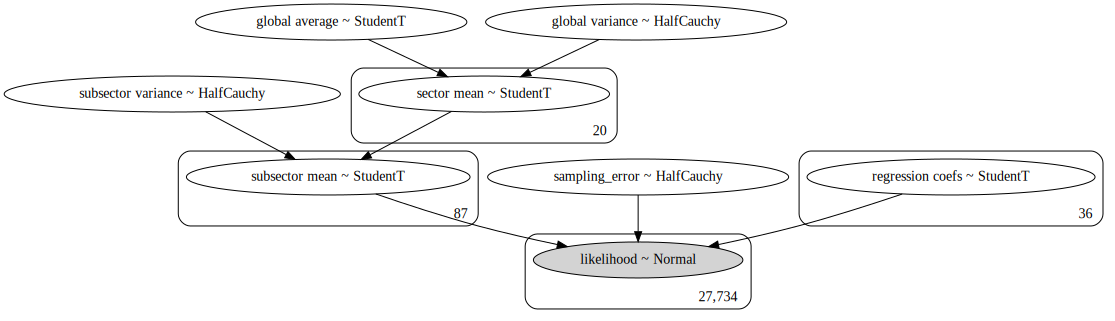

In [128]:
pm.model_to_graphviz(osha_physical_ints_labeled)

In [129]:
with osha_physical_ints:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple seq

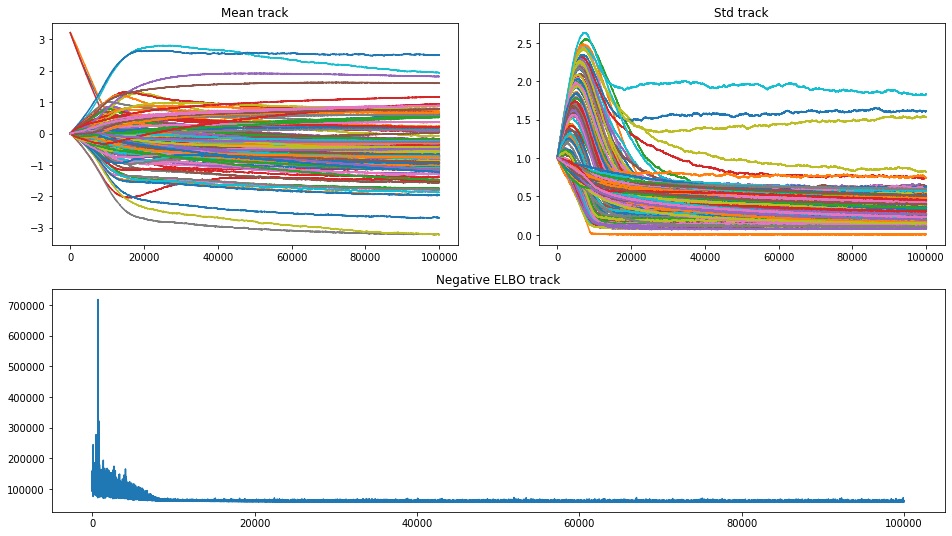

In [130]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

In [131]:
#fig, axes = pm.forestplot(fit.sample(1000), kind='ridgeplot', var_names=['beta'], ridgeplot_overlap=3, colors='white', figsize=(10,5))
#fig.axes[0].set_yticklabels(opera_cols[::-1], size=16)
#fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
#plt.axvline(x=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


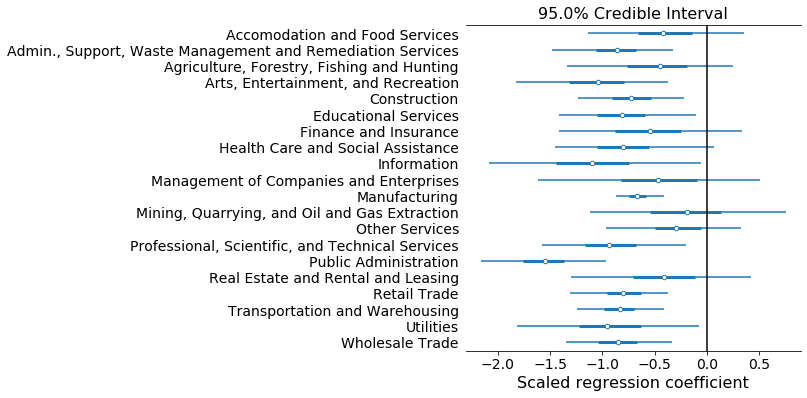

In [132]:
sector_index.loc[1,'sector_name'] = "Admin., Support, Waste Management and Remediation Services"  # make sector label shorter
fig, axes = pm.forestplot(fit.sample(1000), var_names=['sector_int_mu'], credible_interval=0.95)
fig.axes[0].set_yticklabels(sector_index['sector_name'][::-1])
fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
plt.axvline(x=0, color='black')

In [133]:
#fig, axs = pm.forestplot(fit.sample(1000), var_names=['subsector_int'], figsize=(8,18.5), credible_interval=0.95)
#fig.axes[0].set_yticklabels(sector_subsector_index['subsector_name'][::-1])
#fig.axes[0].set_xlabel("Scaled regression coefficient", size=16)
#plt.axvline(x=0, color='black')

## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [134]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_physical_ints)
avg_predictions = ppc['likelihood'].mean(axis=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:06<00:00, 80.16it/s]


#### Classification accuracy metrics

In [135]:
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(indexed_osha['log_mgm3'], avg_predictions,)
rmse = np.sqrt(mean_squared_error(avg_predictions, indexed_osha['log_mgm3']))
print('Training r2: {:.2f}'.format(r2))
print('Training RMSE: {:.2f}'.format(rmse))

Training r2: 0.62
Training RMSE: 2.00


In [136]:
null_predictions = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha['log_mgm3']))
null_r2 = r2_score(indexed_osha['log_mgm3'], null_predictions, )
print('Null model r2: {:.2f}'.format(null_r2))

Null model r2: 0.00


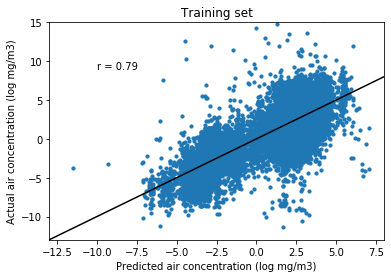

In [137]:
r = np.corrcoef(indexed_osha['log_mgm3'], avg_predictions)[0,1]
plt.scatter(avg_predictions, indexed_osha['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title('Training set')
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

#### Actual vs predicted subsector mean air concentration

In [138]:
subsector_means = indexed_osha[['log_mgm3', 'index_ss']].copy()
subsector_means['conc_predicted'] = avg_predictions
subsector_means = subsector_means.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]

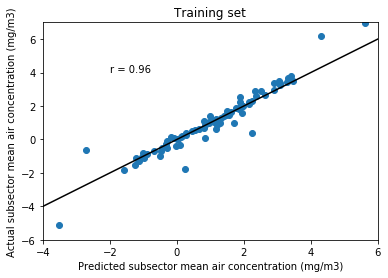

In [139]:
r = np.corrcoef(subsector_means['log_mgm3'], subsector_means['conc_predicted'])[0,1]
plt.scatter( subsector_means['conc_predicted'], subsector_means['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Training set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()

In [140]:
residuals_train = avg_predictions - indexed_osha['log_mgm3']

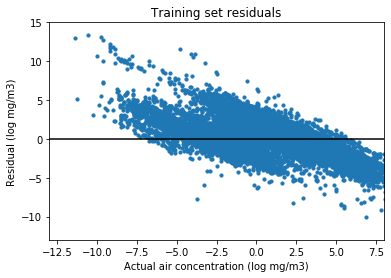

In [143]:
plt.scatter(indexed_osha['log_mgm3'], residuals_train, s=10)
plt.axhline(0, color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Training set residuals")
plt.xlabel('Actual air concentration (log mg/m3)')
plt.ylabel('Residual (log mg/m3)')
plt.show()

### Test set accuracy

In [146]:
preds_test = indexed_osha_test[opera_cols + opera_cols_ints]
conc_shared.set_value(indexed_osha_test.log_mgm3.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_physical_ints)
avg_predictions_test = ppc_test['likelihood'].mean(axis=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 500/500 [00:05<00:00, 84.90it/s]


#### Classification accuracy metrics (test)

In [147]:
from sklearn.metrics import r2_score, mean_squared_error
r2_test = r2_score(indexed_osha_test['log_mgm3'], avg_predictions_test, )
rmse = np.sqrt(mean_squared_error(avg_predictions_test, indexed_osha_test['log_mgm3']))
print('Test r2: {:.2f}'.format(r2_test))
print('Test RMSE: {:.2f}'.format(rmse))

Test r2: 0.59
Test RMSE: 1.88


In [148]:
null_predictions_test = np.repeat(indexed_osha['log_mgm3'].mean(),
                                      repeats=len(indexed_osha_test['log_mgm3']))
null_r2_test = r2_score(null_predictions_test, indexed_osha_test['log_mgm3'])
print('Null model test r2: {:.2f}'.format(null_r2_test))

Null model test r2: -185766300288952737827621217239040.00


In [149]:
test_mean = np.repeat(indexed_osha_test['log_mgm3'].mean(),
                                      repeats=len(indexed_osha_test['log_mgm3']))
test_mean_r2 = r2_score(test_mean, indexed_osha_test['log_mgm3'])
test_mean_rmse = np.sqrt(mean_squared_error(test_mean, indexed_osha_test['log_mgm3']))
print('r2 using mean of test data: {:.2f}'.format(test_mean_r2))
print('RMSE using mean of test data: {:.2f}'.format(test_mean_rmse))

r2 using mean of test data: 0.00
RMSE using mean of test data: 2.93


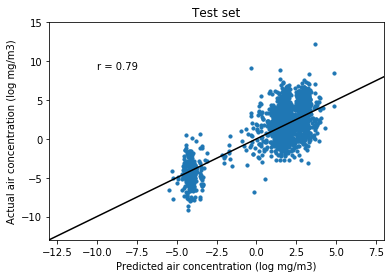

In [150]:
r = np.corrcoef(indexed_osha_test['log_mgm3'], avg_predictions_test)[0,1]
plt.scatter(avg_predictions_test, indexed_osha_test['log_mgm3'], s=10)
plt.plot([-20, 10], [-20, 10], color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set")
plt.xlabel('Predicted air concentration (log mg/m3)')
plt.ylabel('Actual air concentration (log mg/m3)')
plt.text(-10, 9, 'r = {:.2f}'.format(r))
plt.show()

In [152]:
residuals_test = avg_predictions_test - indexed_osha_test['log_mgm3']
residuals_null = indexed_osha['log_mgm3'].mean() - indexed_osha_test['log_mgm3']
residuals_null2 = indexed_osha_test['log_mgm3'].mean() - indexed_osha_test['log_mgm3'] 

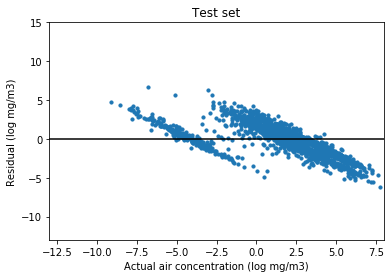

In [153]:
plt.scatter(indexed_osha_test['log_mgm3'], residuals_test, s=10)
plt.axhline(0, color='black')
plt.xlim([-13,8])
plt.ylim([-13,15])
plt.title("Test set")
plt.xlabel('Actual air concentration (log mg/m3)')
plt.ylabel('Residual (log mg/m3)')
plt.show()

#### Actual vs predicted subsector mean air concentration (test)

In [154]:
subsector_means_test = indexed_osha_test[['log_mgm3', 'index_ss']].copy()
subsector_means_test['conc_predicted'] = avg_predictions_test
subsector_means_test = subsector_means_test.groupby('index_ss').mean()
#subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points

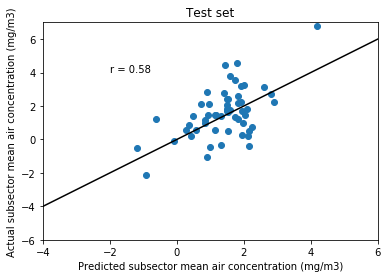

In [155]:
r = np.corrcoef(subsector_means_test['log_mgm3'], subsector_means_test['conc_predicted'])[0,1]
plt.scatter( subsector_means_test['conc_predicted'], subsector_means_test['log_mgm3'])
plt.plot([-4, 7], [-4, 7], color='black')
plt.xlim([-4,6])
plt.ylim([-6,7])
plt.title('Test set')
plt.xlabel('Predicted subsector mean air concentration (mg/m3)')
plt.ylabel('Actual subsector mean air concentration (mg/m3)')
plt.text(-2, 4, 'r = {:.2f}'.format(r))
plt.show()